In [263]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
from pykalman import KalmanFilter

In [288]:
class MomentumStrategy:
    def __init__(self, price_data, leverage, initial_portfolio_value):
        """
        Initialize the MomentumStrategy.

        Parameters:
        - price_data (DataFrame): DataFrame with timestamp indexed asset prices.
        - leverage (float): Leverage factor for trades.
        - initial_portfolio_value (float): Starting portfolio value.
        """
        self.price_data = price_data.copy()
        self.leverage = leverage
        self.initial_portfolio_value = initial_portfolio_value
        # Initialize trade logs with all necessary columns, including 'return'
        self.trade_logs = {asset: pd.DataFrame(columns=['timestamp', 'type', 'price', 'slope', 'return']) 
                           for asset in self.price_data.columns if asset != 'time'}

    def calculate_kalman_filter(self, price_series, initial_state=None, process_var=1e-5, meas_var=0.1):
        """
        Calculate the Kalman filter estimate of the price series using pykalman.
        
        Parameters:
        - price_series (Series): Asset price series.
        - initial_state (float): Initial state estimate (defaults to first price).
        - process_var (float): Process variance (system noise).
        - meas_var (float): Measurement variance (sensor noise).
        
        Returns:
        - Series: Kalman-filtered estimates.
        """
        if initial_state is None:
            initial_state = price_series.iloc[0]
        
        # Initialize Kalman Filter
        kf = KalmanFilter(
            transition_matrices=[1],  # State transition matrix (scalar for 1D)
            observation_matrices=[1],  # Observation matrix (scalar for 1D)
            initial_state_mean=initial_state,
            initial_state_covariance=1.0,
            transition_covariance=process_var,
            observation_covariance=meas_var
        )
        
        # Apply Kalman Filter
        state_means, _ = kf.filter(price_series.values)
        return pd.Series(state_means.flatten(), index=price_series.index)
        
    def calculate_moving_avg(self, price_series, window):
        """
        Calculate the moving average of the price series.

        Parameters:
        - price_series (Series): Asset price series.
        - window (int): Window size for moving average.

        Returns:
        - Series: Moving average series.
        """
        return price_series.rolling(window=window).mean()

    def calculate_percentage_slope(self, moving_avg_series):
        """
        Calculate the percentage slope of the moving average.

        Parameters:
        - moving_avg_series (Series): Moving average series.

        Returns:
        - Series: Percentage slope values.
        """
        slope = (moving_avg_series.diff(1) / moving_avg_series.shift(1)) * 100
        slope = slope.fillna(0)  # Replace NaN values with 0
        return slope

    def simulate_trade_with_percentage_slope(self, market, position_size, entry_threshold, exit_threshold, window=None, use_kalman=False, kalman_params=None):
        """
        Simulate trading for a single market using percentage-based slope values and record trade returns.

        Parameters:
        - market (str): Market identifier (column name in price_data).
        - position_size (float): Size of each position.
        - entry_threshold (float): Threshold for entering trades.
        - exit_threshold (float): Threshold for exiting trades.
        - window (int): Window size for moving average and slope calculation.

        Returns:
        - float: Final portfolio value after trading.
        """
        price_series = self.price_data[market]
        if use_kalman:
            kalman_params = kalman_params or {}
            print(f"Processing market: {market}, price_series shape: {price_series.shape}")
            filtered_series = self.calculate_kalman_filter(price_series, **kalman_params)
        else:
            filtered_series = self.calculate_moving_avg(price_series, window)
            slope_series = self.calculate_percentage_slope(filtered_series)

        # Handle NaN values by filling forward or setting to zero
        slope_series = slope_series.fillna(0)

        # Initialize portfolio values tracking
        portfolio_value = self.initial_portfolio_value
        in_position = False
        position_type = None  # "long" or "short"
        entry_price = 0.0

        for idx in range(len(self.price_data)):
            current_slope = slope_series.iloc[idx]
            current_price = price_series.iloc[idx]
            current_time = slope_series.index[idx]

            # Entry Conditions
            if not in_position:
                # Long Entry
                if current_slope >= entry_threshold:
                    in_position = True
                    position_type = "long"
                    entry_price = current_price
                    # Log the trade
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_entry',
                        'price': entry_price,
                        'slope': current_slope,
                        'return': np.nan  # Placeholder for exit return
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)

                # Short Entry
                elif current_slope <= -entry_threshold:
                    in_position = True
                    position_type = "short"
                    entry_price = current_price
                    # Log the trade
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_entry',
                        'price': entry_price,
                        'slope': current_slope,
                        'return': np.nan  # Placeholder for exit return
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)

            # Exit Conditions
            else:
                if position_type == "long" and current_slope <= exit_threshold:
                    # Calculate price change
                    price_change = (current_price - entry_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    # Assume a trading fee (e.g., 0.1%)
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    # Log the trade exit with return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_exit',
                        'price': current_price,
                        'slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                    # Reset position
                    in_position, position_type, entry_price = False, None, None

                elif position_type == "short" and current_slope >= -exit_threshold:
                    # Calculate price change for short
                    price_change = (entry_price - current_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    # Assume a trading fee (e.g., 0.1%)
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    # Log the trade exit with return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_exit',
                        'price': current_price,
                        'slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                    # Reset position
                    in_position, position_type, entry_price = False, None, None

        # Exiting the last open position at the end of the data
        if in_position:
            final_price = price_series.iloc[-1]
            final_time = slope_series.index[-1]
            if position_type == "long":
                price_change = (final_price - entry_price) / entry_price
                trade_type = 'long_exit'
            elif position_type == "short":
                price_change = (entry_price - final_price) / entry_price
                trade_type = 'short_exit'
            leveraged_return = price_change * position_size * self.leverage
            trading_fee = position_size * self.leverage * 0.001
            trade_return = leveraged_return - trading_fee
            portfolio_value += trade_return
            # Log the trade exit with return
            new_row = pd.DataFrame([{
                'timestamp': final_time,
                'type': trade_type,
                'price': final_price,
                'slope': slope_series.iloc[-1],
                'return': trade_return
            }])
            self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)

        return portfolio_value

    def trade_all_markets_with_percentage_slope(self, window, position_size, entry_threshold, exit_threshold, use_kalman=False, kalman_params=None):
        """
        Simulate trading across all markets using percentage-based slope values.

        Parameters:
        - window (int): Window size for moving average and slope calculation.
        - position_size (float): Size of each position.
        - entry_threshold (float): Threshold for entering trades.
        - exit_threshold (float): Threshold for exiting trades.

        Returns:
        - float: Aggregate returns across all markets.
        """
        total_returns = 0.0
        for market in self.price_data.columns:
            if market == 'time':
                continue

            final_portfolio = self.simulate_trade_with_percentage_slope(
                market=market,
                position_size=position_size,
                entry_threshold=entry_threshold,
                exit_threshold=exit_threshold,
                window=window,
                use_kalman=use_kalman,
                kalman_params=kalman_params
            )
            returns = final_portfolio - self.initial_portfolio_value
            total_returns += returns

        return total_returns

    def run_monte_carlo_simulation_with_percentage_slope(self, iterations, window_range, entry_threshold_range, exit_threshold_range, output_name, use_kalman=False, kalman_params=None, save_path='simulation_results'):
        """
        Run Monte Carlo simulations using percentage-based slope values.

        Parameters:
        - iterations (int): Number of simulation iterations.
        - window_range (tuple): Tuple indicating the range (min, max) for window sizes.
        - entry_threshold_range (tuple): Tuple indicating the range (min, max) for entry thresholds.
        - exit_threshold_range (tuple): Tuple indicating the range (min, max) for exit thresholds.
        - output_name (str): Base name for the output JSON file.
        - save_path (str): Directory path to save simulation results.

        Returns:
        - list: List of simulation result dictionaries.
        """
        simulation_results = []

        # Create directory if it doesn't exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i in range(iterations):
            WINDOW = np.random.randint(*window_range)
            POSITION_SIZE = 1
            ENTRY_THRESHOLD = np.random.uniform(*entry_threshold_range)
            EXIT_THRESHOLD = np.random.uniform(*exit_threshold_range)
            total_returns = self.trade_all_markets_with_percentage_slope(
                window=WINDOW,
                position_size=POSITION_SIZE,
                entry_threshold=ENTRY_THRESHOLD,
                exit_threshold=EXIT_THRESHOLD,
                use_kalman=use_kalman,
                kalman_params=kalman_params
            )
            simulation_results.append({
                'returns': total_returns,
                'window': WINDOW,
                'position_size': POSITION_SIZE,
                'entry_threshold': ENTRY_THRESHOLD,
                'exit_threshold': EXIT_THRESHOLD,
                'use_kalman': use_kalman,
                'kalman_params': kalman_params
            })
            if (i+1) % 10 == 0 or (i+1) == iterations:
                print(f"Completed {i+1}/{iterations} simulations.")

        # Save all simulation results to a JSON file
        with open(os.path.join(save_path, f'{output_name}_percentage_slope_simulation_results.json'), 'w') as f:
            json.dump(simulation_results, f, indent=4)

        return simulation_results

    def plot_trade_histogram(self, market, profitability_axis='return', bins=50):
        """
        Plot a histogram of trade profitability for a specified market.

        Parameters:
        - market (str): Market identifier.
        - profitability_axis (str): The column to analyze for profitability ('return', 'slope_change', etc.).
        - bins (int): Number of bins for the histogram.
        """
        if market not in self.trade_logs:
            print(f"No trade data available for {market}.")
            return

        trades = self.trade_logs[market]

        # Pair entries and exits
        trades = trades.sort_values(by='timestamp')
        trades = trades.reset_index(drop=True)

        paired_trades = []
        i = 0
        while i < len(trades) - 1:
            entry = trades.iloc[i]
            exit = trades.iloc[i+1]
            if ((entry.type in ['long_entry', 'short_entry']) and 
                ((entry.type == 'long_entry' and exit.type == 'long_exit') or 
                 (entry.type == 'short_entry' and exit.type == 'short_exit'))):
                # Calculate profitability
                if entry.type == 'long_entry':
                    profit = (exit.price - entry.price) / entry.price * self.leverage
                else:  # short_entry
                    profit = (entry.price - exit.price) / entry.price * self.leverage
                paired_trades.append(profit)
                i += 2
            else:
                i += 1  # Skip unmatched trades

        if not paired_trades:
            print(f"No complete trade pairs to analyze for {market}.")
            return

        # Convert to numpy array for convenience
        paired_trades = np.array(paired_trades)

        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.hist(paired_trades, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Profitability Distribution for Trades in {market}')
        plt.xlabel('Profit/Loss (%)')
        plt.ylabel('Number of Trades')
        plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
        plt.show()

    def plot_trade_counts(self):
        """
        Plot the number of trades per asset.
        """
        trade_counts = {market: len(df) // 2 for market, df in self.trade_logs.items()}  # Each trade has entry and exit
        trade_counts = pd.Series(trade_counts)

        # Plot bar chart
        trade_counts.plot(kind='bar', figsize=(12, 6), color='lightgreen', edgecolor='black')
        plt.title('Number of Trades per Asset')
        plt.xlabel('Asset')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def save_trade_logs(self, save_path='trade_logs'):
        """
        Save trade logs for all assets to CSV files.

        Parameters:
        - save_path (str): Directory path to save trade logs.
        """
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for market, df in self.trade_logs.items():
            if not df.empty:
                df.to_csv(os.path.join(save_path, f'{market}_trade_log.csv'), index=False)
                print(f"Saved trade log for {market} to {save_path}.")
            else:
                print(f"No trades to save for {market}.")

    # Additional methods for further analysis can be added here


In [162]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_percentage_slope(2000, (100, 150), (0.01, 0.30), (-0.05, 0.01), 'window', './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/2000 simulations.
Completed 20/2000 simulations.
Completed 30/2000 simulations.
Completed 40/2000 simulations.
Completed 50/2000 simulations.
Completed 60/2000 simulations.
Completed 70/2000 simulations.
Completed 80/2000 simulations.
Completed 90/2000 simulations.
Completed 100/2000 simulations.
Completed 110/2000 simulations.
Completed 120/2000 simulations.
Completed 130/2000 simulations.
Completed 140/2000 simulations.
Completed 150/2000 simulations.
Completed 160/2000 simulations.
Completed 170/2000 simulations.
Completed 180/2000 simulations.
Completed 190/2000 simulations.
Completed 200/2000 simulations.
Completed 210/2000 simulations.
Completed 220/2000 simulations.
Completed 230/2000 simulations.
Completed 240/2000 simulations.
Completed 250/2000 simulations.
Completed 260/2000 simulations.
Completed 270/2000 simulations.
Completed 280/2000 simulations.
Completed 290/2000 simulations.
Completed 300/2000 simulations.
Completed 310/2000 simulations.
Completed 320/200

In [163]:
# Load the simulation results
with open('window_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(30)

,returns,window,position_size,entry_threshold,exit_threshold
255,350.203706,127,1,0.026307,-0.029707
1828,336.611921,133,1,0.031545,-0.024298
302,328.778359,135,1,0.028537,-0.015363
12,321.907150,136,1,0.027461,-0.008211
73,320.985687,136,1,0.020378,-0.023017
1752,298.624944,134,1,0.024431,-0.015178
1064,297.794087,129,1,0.034019,-0.026422
1281,292.288610,136,1,0.019625,-0.026552
1513,287.484204,118,1,0.032064,-0.038699
839,287.283982,129,1,0.038717,-0.020544


In [164]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold
592,-308.670270,104,1,0.023792,-0.000727
1629,-315.113043,102,1,0.030176,0.000805
1460,-325.641767,101,1,0.028103,0.002246
355,-327.171716,102,1,0.026133,-0.007256
1677,-359.103514,108,1,0.011062,0.005105
641,-378.814131,101,1,0.024667,-0.002134
1973,-383.123204,100,1,0.024792,0.000173
899,-404.262831,100,1,0.017881,-0.011940
418,-412.794846,102,1,0.016834,-0.009520
737,-499.184918,103,1,0.017529,-0.003500


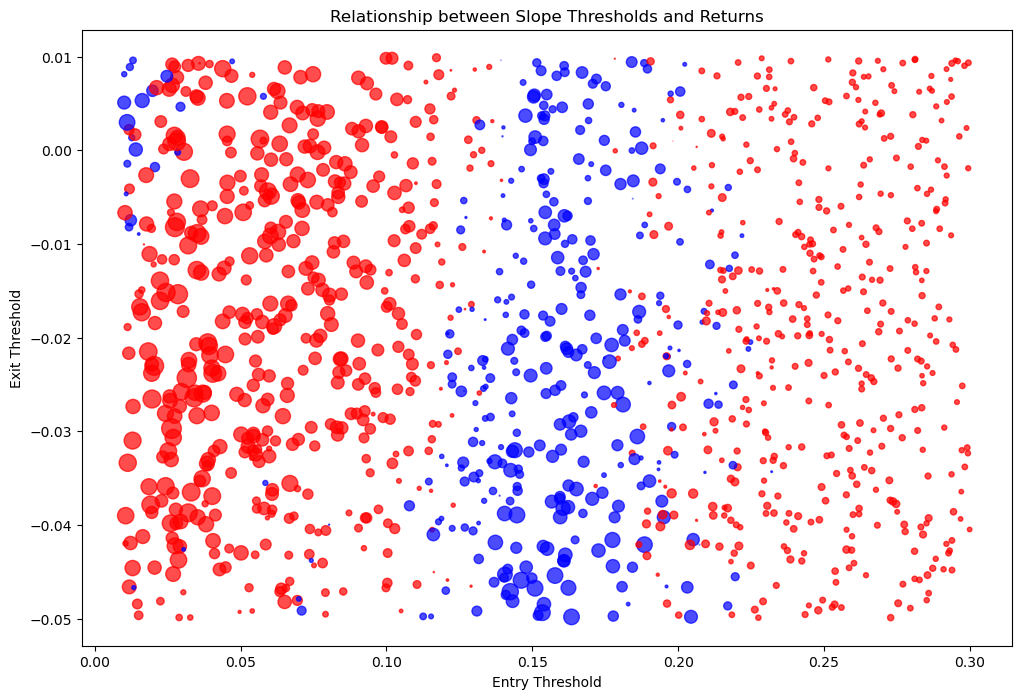

In [171]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the simulation results
with open('window_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Filter the DataFrame for the specified window range
filtered_df = df[(df['window'] >= 110) & (df['window'] <= 140)].copy()

# Create a column for colors (red for positive, blue for negative)
filtered_df['color'] = filtered_df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
filtered_df['size'] = filtered_df['returns'].abs() / filtered_df['returns'].abs().max() * 200  # Normalize sizes

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    x=filtered_df['entry_threshold'],
    y=filtered_df['exit_threshold'],
    c=filtered_df['color'],  # Use the 'color' column for point colors
    s=filtered_df['size'],   # Use the 'size' column for point sizes
    alpha=0.7                # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between Slope Thresholds and Returns')
plt.xlabel('Entry Threshold')
plt.ylabel('Exit Threshold')

# Show the plot
plt.show()


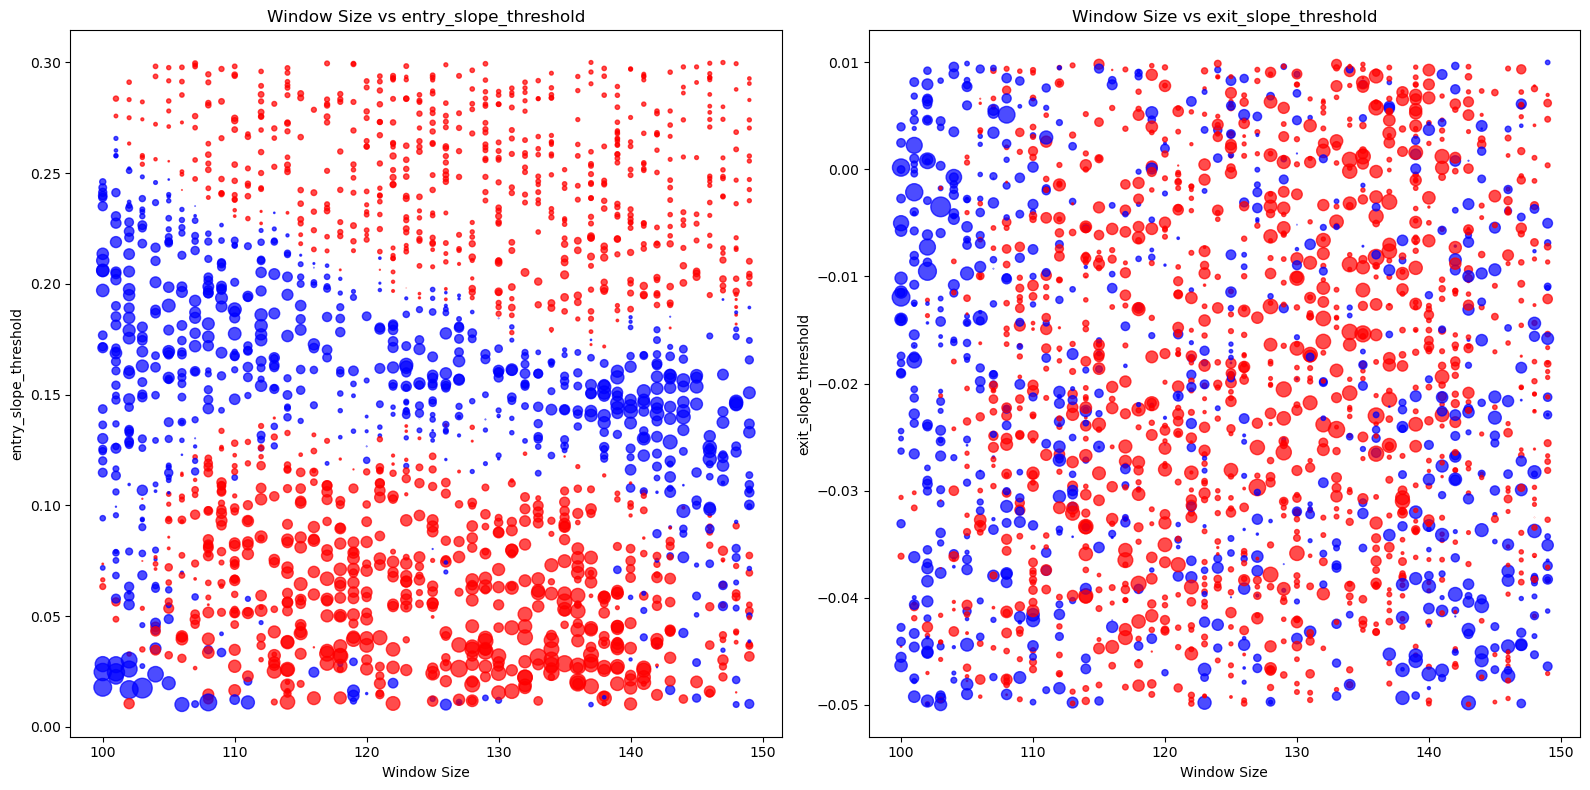

In [166]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [108]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_percentage_slope(500, (100, 200), (0.01, 0.30), (-0.06, 0.01), 'test', './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [113]:
# Load the simulation results
with open('test_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(30)

,returns,window,position_size,entry_threshold,exit_threshold
493,303.592837,131,1,0.010049,-0.024125
473,301.050663,140,1,0.011016,-0.024225
0,300.040928,184,1,0.018398,-0.010874
205,292.777502,133,1,0.039728,-0.009917
483,289.654406,180,1,0.026494,-0.027016
215,269.908229,115,1,0.028954,-0.032270
136,269.203885,128,1,0.032793,-0.009425
175,263.564410,187,1,0.010176,-0.003778
444,260.145280,188,1,0.028516,-0.004255
164,250.441613,127,1,0.035020,-0.007920


In [110]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold
359,-246.281084,173,1,0.130284,0.001166
351,-254.807445,163,1,0.161078,-0.009666
310,-259.291918,193,1,0.125633,0.006619
157,-264.214138,160,1,0.148959,-0.010626
55,-264.357678,197,1,0.115577,-0.040272
494,-267.274354,158,1,0.147885,-0.007046
109,-299.852149,145,1,0.136390,-0.054997
300,-300.537114,175,1,0.143236,0.007343
415,-320.042337,104,1,0.017382,-0.012013
132,-370.601587,104,1,0.014507,-0.010796


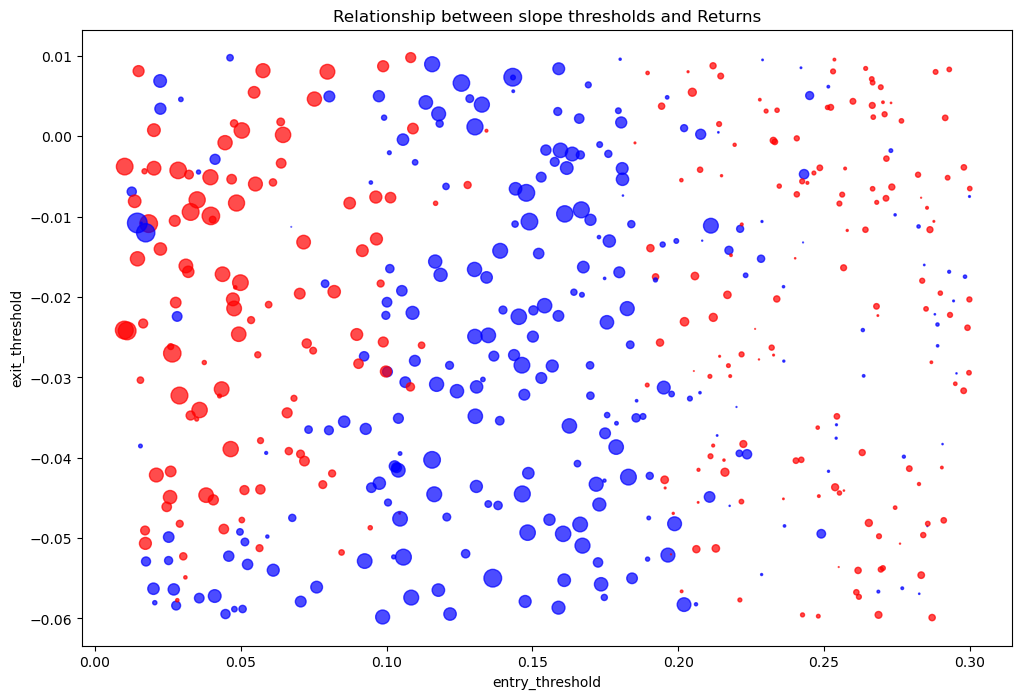

In [111]:
# Load the simulation results
with open('test_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes to range [0, 200]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(
    x=df['entry_threshold'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between slope thresholds and Returns')
plt.xlabel('entry_threshold')
plt.ylabel('exit_threshold')

plt.show()

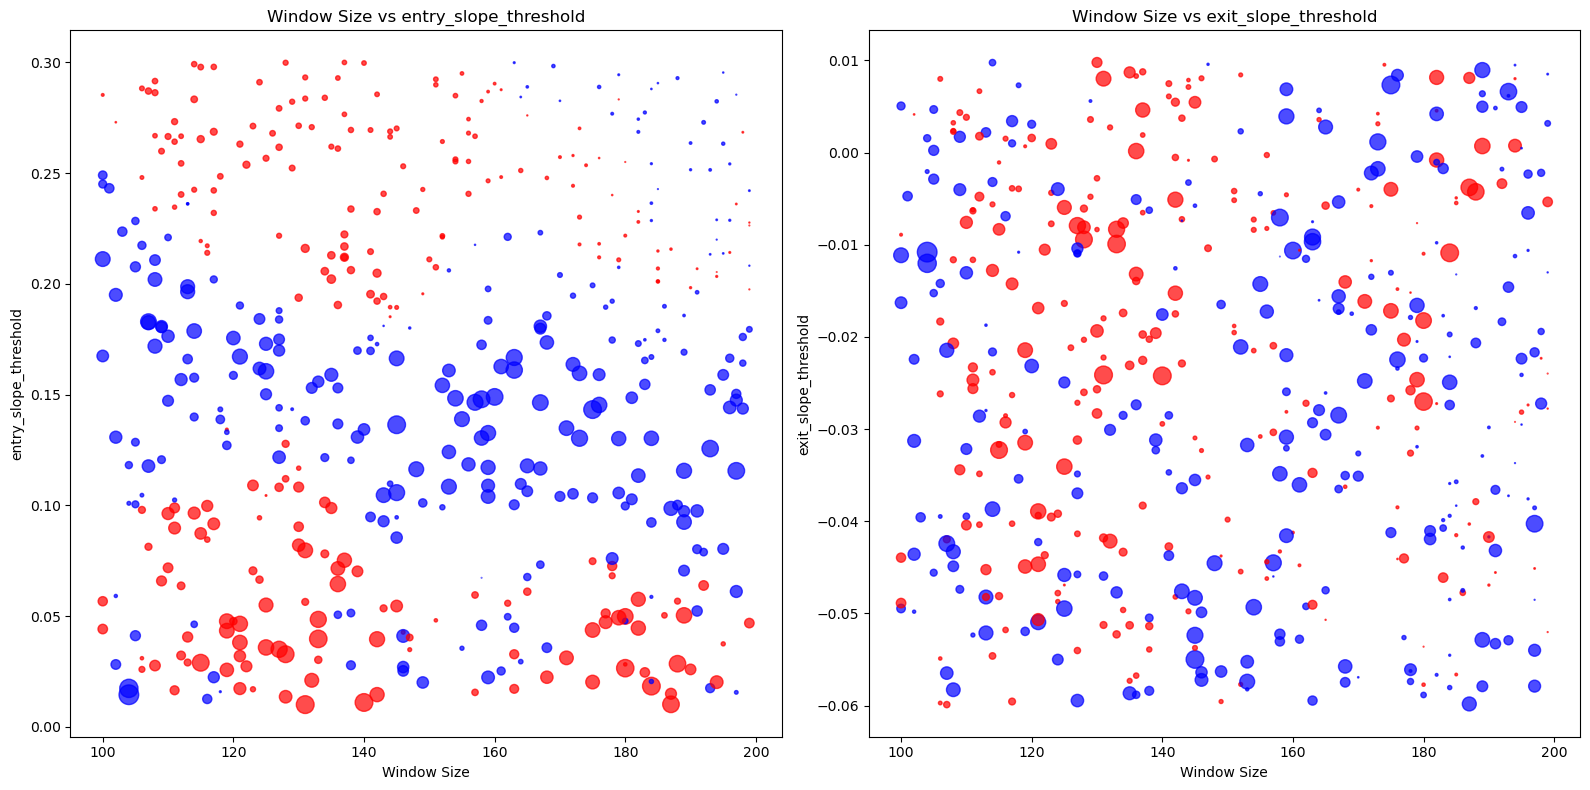

In [112]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [148]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
# Simulate trading for DOGEUSDT
final_portfolio_value = strategy.simulate_trade_with_percentage_slope(
    market='DOTUSDT',
    position_size=2,
    entry_threshold=0.01,
    exit_threshold=-0.024,
    window=135
)

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

Final Portfolio Value: $2040.52


/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


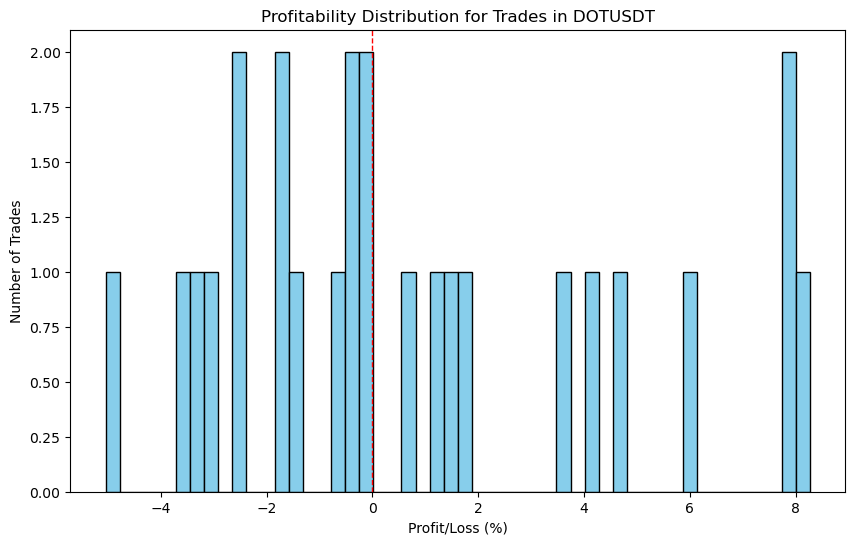

In [149]:
# Plot the profitability distribution for trades
strategy.plot_trade_histogram(
    market='DOTUSDT',
    profitability_axis='return',  # Column 'return' in trade_logs contains profitability
    bins=50
)

In [114]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv'), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_percentage_slope(300, (100, 150), (0.01, 0.15), (-0.05, 0.01), 'final', './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/300 simulations.
Completed 20/300 simulations.
Completed 30/300 simulations.
Completed 40/300 simulations.
Completed 50/300 simulations.
Completed 60/300 simulations.
Completed 70/300 simulations.
Completed 80/300 simulations.
Completed 90/300 simulations.
Completed 100/300 simulations.
Completed 110/300 simulations.
Completed 120/300 simulations.
Completed 130/300 simulations.
Completed 140/300 simulations.
Completed 150/300 simulations.
Completed 160/300 simulations.
Completed 170/300 simulations.
Completed 180/300 simulations.
Completed 190/300 simulations.
Completed 200/300 simulations.
Completed 210/300 simulations.
Completed 220/300 simulations.
Completed 230/300 simulations.
Completed 240/300 simulations.
Completed 250/300 simulations.
Completed 260/300 simulations.
Completed 270/300 simulations.
Completed 280/300 simulations.
Completed 290/300 simulations.
Completed 300/300 simulations.


In [115]:
# Load the simulation results
with open('final_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(10)

,returns,window,position_size,entry_threshold,exit_threshold
204,1443.973469,142,1,0.011563,-0.028100
244,1408.360718,141,1,0.034125,-0.035252
172,1241.300569,142,1,0.037991,-0.025676
39,1226.910060,144,1,0.020020,-0.034887
80,1199.440727,109,1,0.033361,-0.046198
170,1177.286658,138,1,0.016777,-0.021534
133,1158.822385,142,1,0.040429,-0.034630
195,1141.984567,103,1,0.032393,-0.042381
222,1107.936506,132,1,0.034291,-0.023502
224,1090.357205,105,1,0.025234,-0.039597


In [116]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold
257,NaN,138,1,0.018700,0.004061
259,NaN,105,1,0.014566,0.003847
260,NaN,105,1,0.040723,0.002945
261,NaN,111,1,0.022117,0.005635
264,NaN,141,1,0.030039,0.005966
276,NaN,104,1,0.078338,0.001867
287,NaN,130,1,0.144298,0.002438
293,NaN,147,1,0.071870,0.008197
295,NaN,141,1,0.034307,0.005539
297,NaN,133,1,0.138494,0.004895


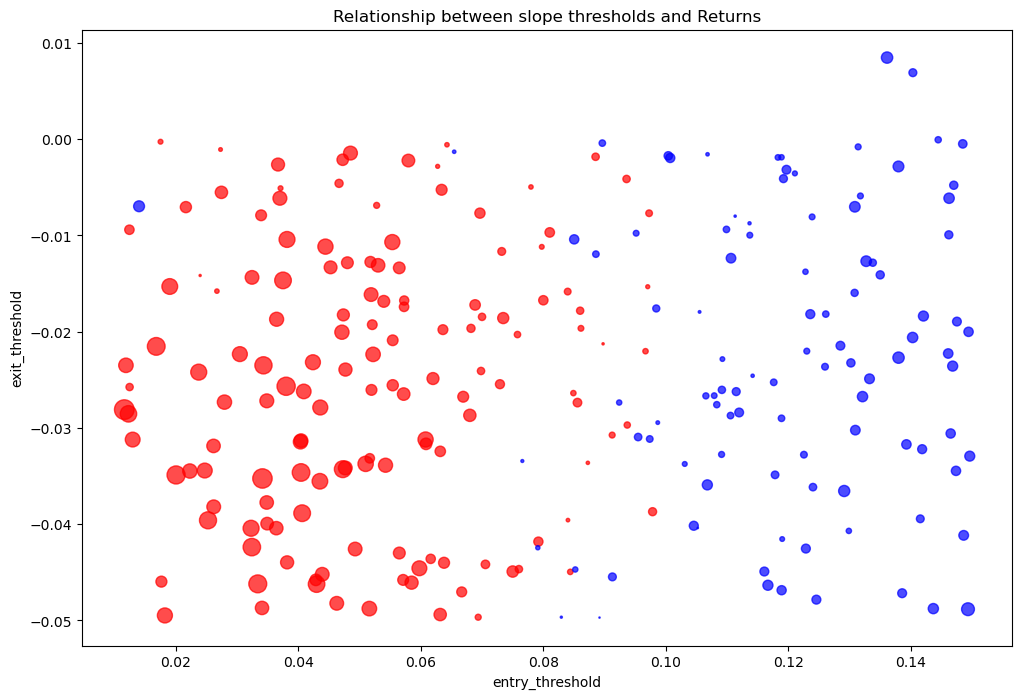

In [117]:
# Load the simulation results
with open('final_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes to range [0, 200]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(
    x=df['entry_threshold'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between slope thresholds and Returns')
plt.xlabel('entry_threshold')
plt.ylabel('exit_threshold')

plt.show()

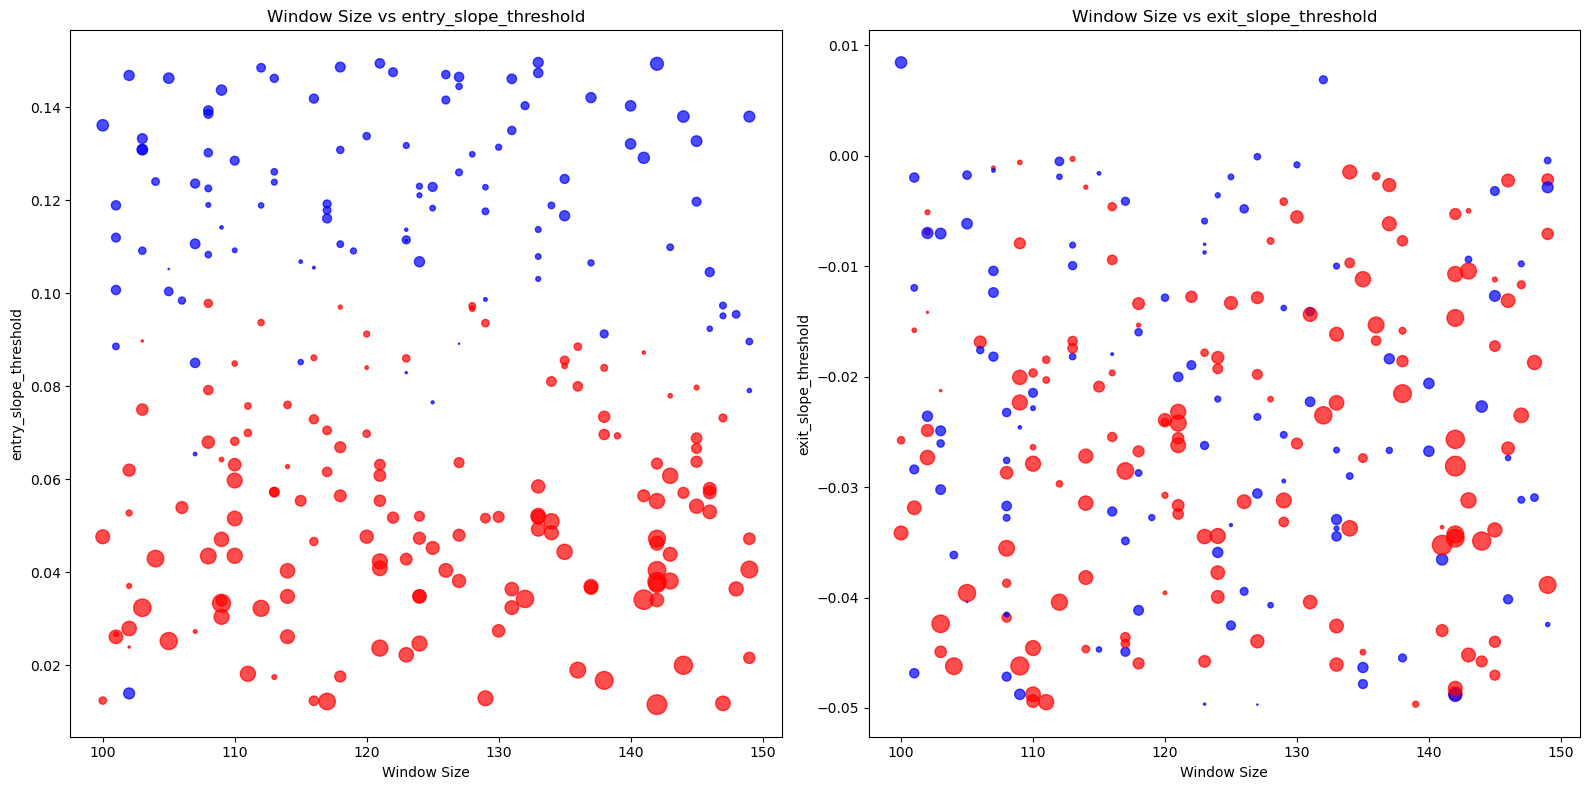

In [118]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [221]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(4000), 50, 2000)

final_portfolio_value = strategy.simulate_trade_with_percentage_slope(
    market='DOGEUSDT',
    position_size=1,
    entry_threshold=0.27,
    exit_threshold=-0.22,
    window=19
)

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

Final Portfolio Value: $2009.95


/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


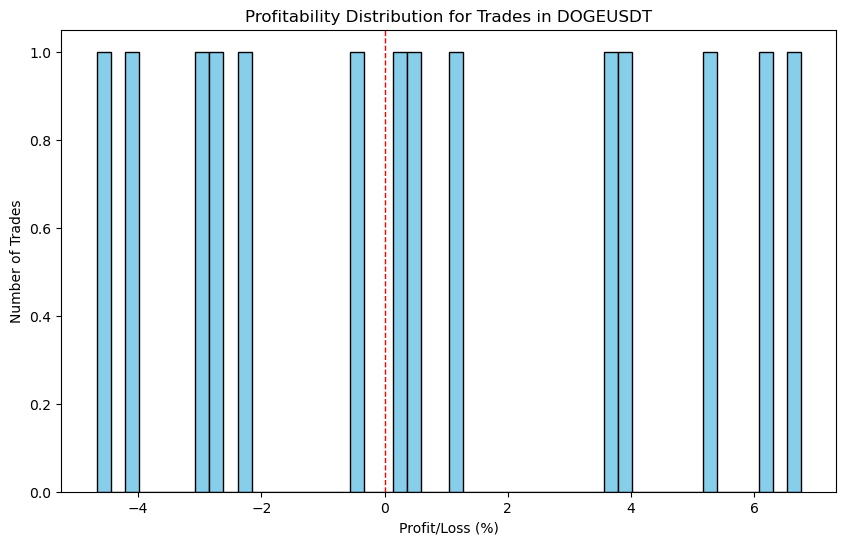

In [222]:
# Plot the profitability distribution for DOGEUSDT trades
strategy.plot_trade_histogram(
    market='DOGEUSDT',
    profitability_axis='return',  # Column 'return' in trade_logs contains profitability
    bins=50
)

In [223]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv'), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_percentage_slope(1000, (300, 700), (0.01, 0.05), (-0.05, 0.005), 'big', './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3392571785.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


KeyboardInterrupt: 

In [183]:
# Load the simulation results
with open('big_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(50)

,returns,window,position_size,entry_threshold,exit_threshold
169,1107.093186,384,1,0.011575,-0.011488
969,1058.500225,311,1,0.012677,-0.015483
43,1050.102412,375,1,0.010778,-0.004147
925,1034.363316,384,1,0.011337,-0.012761
120,1023.661979,393,1,0.010891,-0.003086
61,1014.773522,476,1,0.011395,-0.001051
442,1011.510723,589,1,0.011159,-0.004563
934,1007.828052,454,1,0.013201,0.002277
228,1007.687743,506,1,0.012338,-0.002151
657,1003.186389,396,1,0.012264,-0.007160


In [184]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold
348,-196.078800,661,1,0.039256,-0.032978
578,-197.906058,670,1,0.011469,-0.039366
221,-205.304941,539,1,0.047489,-0.005088
715,-213.812506,677,1,0.037126,-0.007361
6,-260.161987,675,1,0.036625,-0.035778
556,-286.175745,685,1,0.045412,-0.034583
53,-320.913650,693,1,0.046799,-0.023529
577,-360.624772,694,1,0.023292,-0.049027
576,-413.197051,697,1,0.049521,-0.032366
660,-455.371663,693,1,0.049586,-0.032078


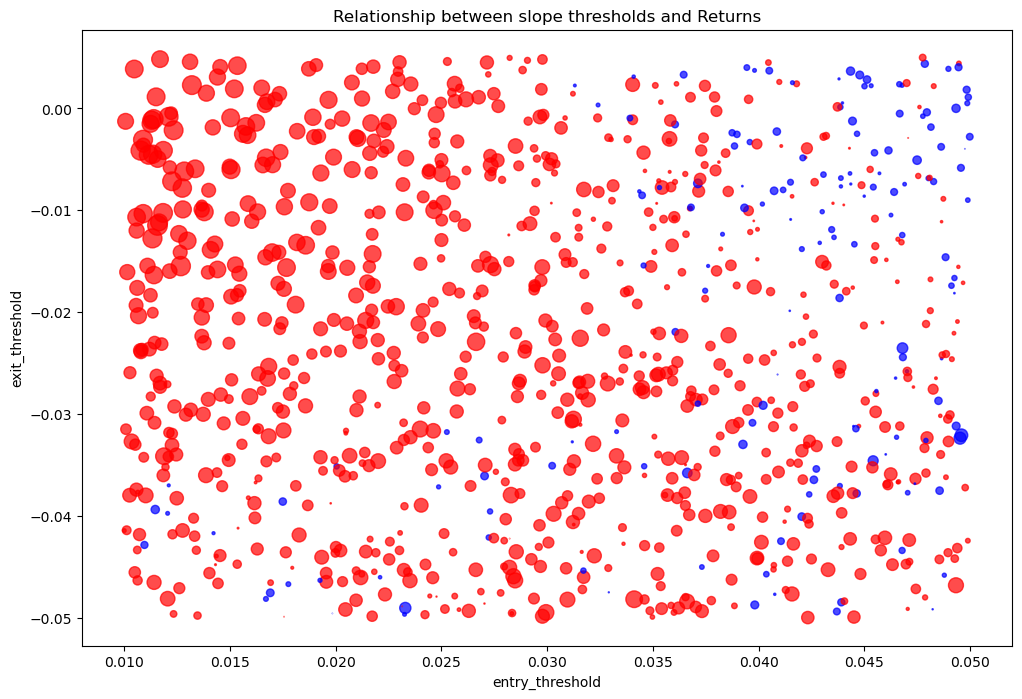

In [185]:
# Load the simulation results
with open('big_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes to range [0, 200]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(
    x=df['entry_threshold'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between slope thresholds and Returns')
plt.xlabel('entry_threshold')
plt.ylabel('exit_threshold')

plt.show()

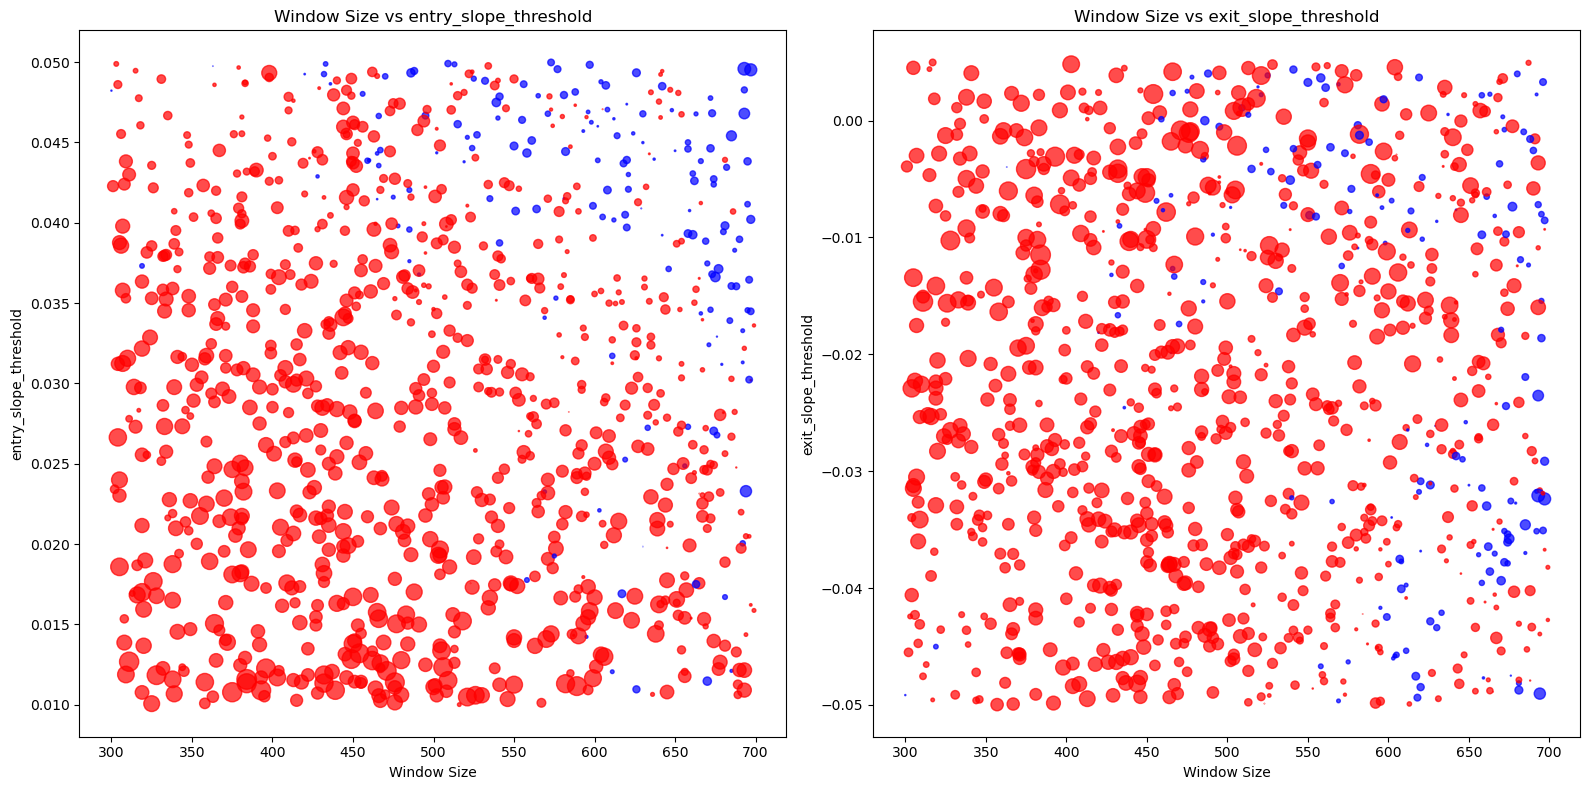

In [186]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [291]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_percentage_slope(500, (5, 50), (0.005, 0.6), (-0.6, 0.004), 'small', False, None, './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3439097534.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_32707/3439097534.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [292]:
# Load the simulation results
with open('small_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(30)

,returns,window,position_size,entry_threshold,exit_threshold,use_kalman,kalman_params
240,335.989460,32,1,0.192467,-0.388390,False,None
442,329.761069,22,1,0.069347,-0.538546,False,None
25,327.607290,24,1,0.231303,-0.452496,False,None
335,321.011071,19,1,0.037657,-0.562303,False,None
121,314.980373,19,1,0.254739,-0.543462,False,None
471,300.720902,21,1,0.144980,-0.559916,False,None
105,293.544894,28,1,0.049660,-0.438276,False,None
311,291.973199,39,1,0.155346,-0.336410,False,None
451,264.377667,31,1,0.270769,-0.410646,False,None
160,256.489415,28,1,0.045925,-0.376775,False,None


In [293]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold,use_kalman,kalman_params
453,-542.992889,8,1,0.010697,-0.142531,False,None
1,-570.611080,6,1,0.210175,-0.069713,False,None
113,-576.320484,8,1,0.171253,-0.099953,False,None
357,-576.625425,8,1,0.272398,-0.000238,False,None
282,-583.803053,9,1,0.095894,-0.040614,False,None
381,-631.117460,6,1,0.109780,-0.208754,False,None
481,-667.940868,6,1,0.189487,-0.052201,False,None
294,-682.503478,23,1,0.009259,-0.007074,False,None
177,-810.841337,5,1,0.007921,-0.243551,False,None
491,-846.851835,6,1,0.127621,-0.024978,False,None


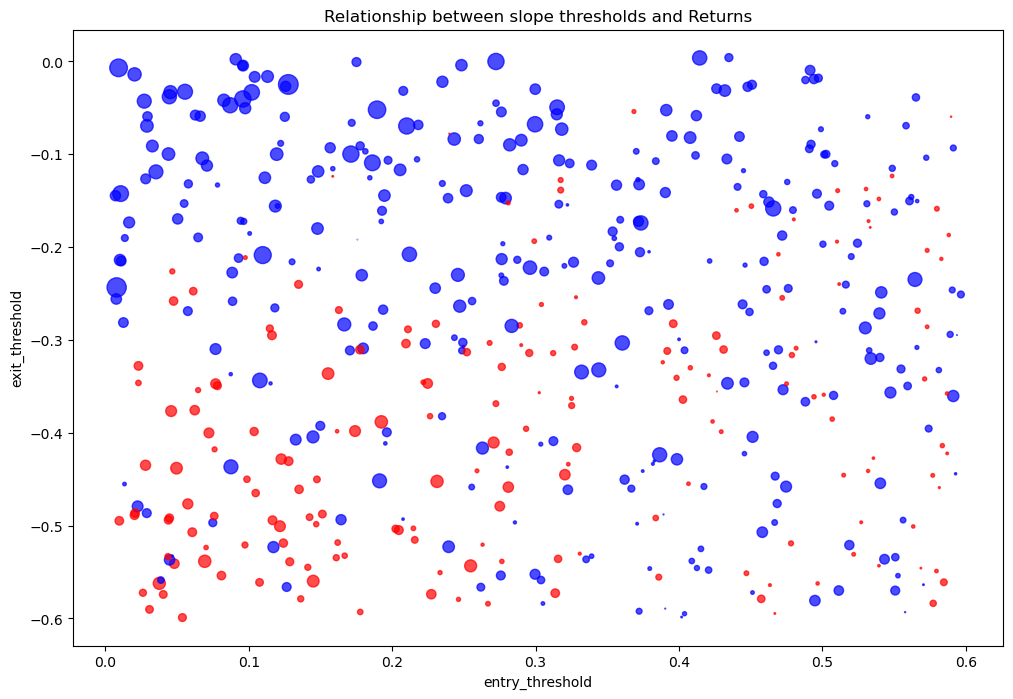

In [294]:
# Load the simulation results
with open('small_percentage_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes to range [0, 200]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(
    x=df['entry_threshold'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between slope thresholds and Returns')
plt.xlabel('entry_threshold')
plt.ylabel('exit_threshold')

plt.show()

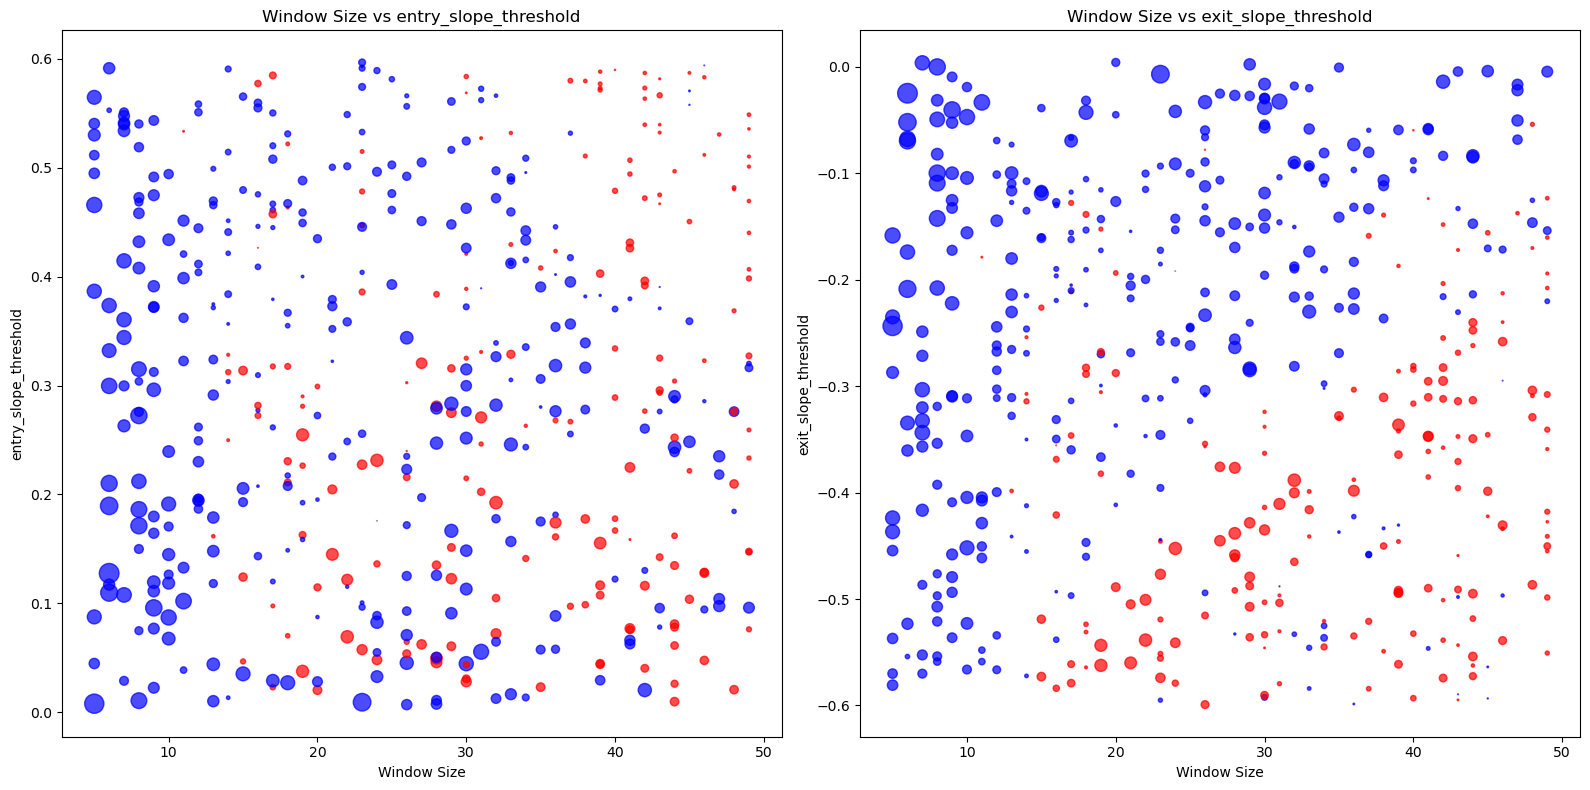

In [295]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [280]:
kf = KalmanFilter(
    transition_matrices=[1],  # 1D transition matrix
    observation_matrices=[1],  # 1D observation matrix
    initial_state_mean=0,
    initial_state_covariance=1.0,
    transition_covariance=1e-5,
    observation_covariance=0.1
)

data = pd.read_csv('data_new.csv').tail(3000)
#data = data[['time', 'UNIUSDT']].copy()
strategy = MomentumStrategy(data, 50, 2000)

state_means, _ = kf.filter(strategy.price_series.values)

AttributeError: 'MomentumStrategy' object has no attribute 'price_series'

In [274]:

kalman_results = strategy.run_monte_carlo_simulation_with_percentage_slope(
    iterations=500,
    window_range=(50, 300),
    entry_threshold_range=(0.005, 0.4),
    exit_threshold_range=(-0.3, 0.004),
    output_name='kalman_sim',
    use_kalman=True,
    kalman_params={
        'process_var': (1e-6, 1e-4),
        'meas_var': (0.01, 0.5)
    })

Processing market: XRPUSDT, price_series shape: (3000,)


ValueError: shapes (1,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)